In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

<module 'visualization' from '/project/6035200/tomren/jupyter/tracker_6layers/visualization.py'>

In [3]:
vertex_xyz = np.array([124.5, 5, 1])*100 # [cm]
vertex_xyz = np.array([124.5, 5, 10])*100 # [cm]
box_lim = np.array([124.5-40, 5, 10])*100  # [cm], Set the vertex to 10m below the edge module


In [4]:
vertex=box_lim
# vertex=vertex_xyz
vertex_CMS = np.array([vertex[1], -vertex[2]+85.47*100, vertex[0]])
vertex_DET = np.array([vertex[0]/100-70-49.5, vertex[1]/100, -vertex[2]/100])

### Inspect the simulation

In [5]:
filename = f"{DATA_DIR}/XtoMuMu_M4GeV_P40GeV//20230523/131132/run0.root"
filename = glob.glob(f"{DATA_DIR}/XtoMuMu_M4GeV_P40GeV/*/*/run0.root",)[0]
# filename = f"{DATA_DIR}/XtoMuMu_P10GeV_manual/20230523/131132//run0.root"
tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)

Number of events 10000


In [7]:
Tree.GetEntry(0)
util.c2list(Tree.GenParticle_x)

[84500.0]

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


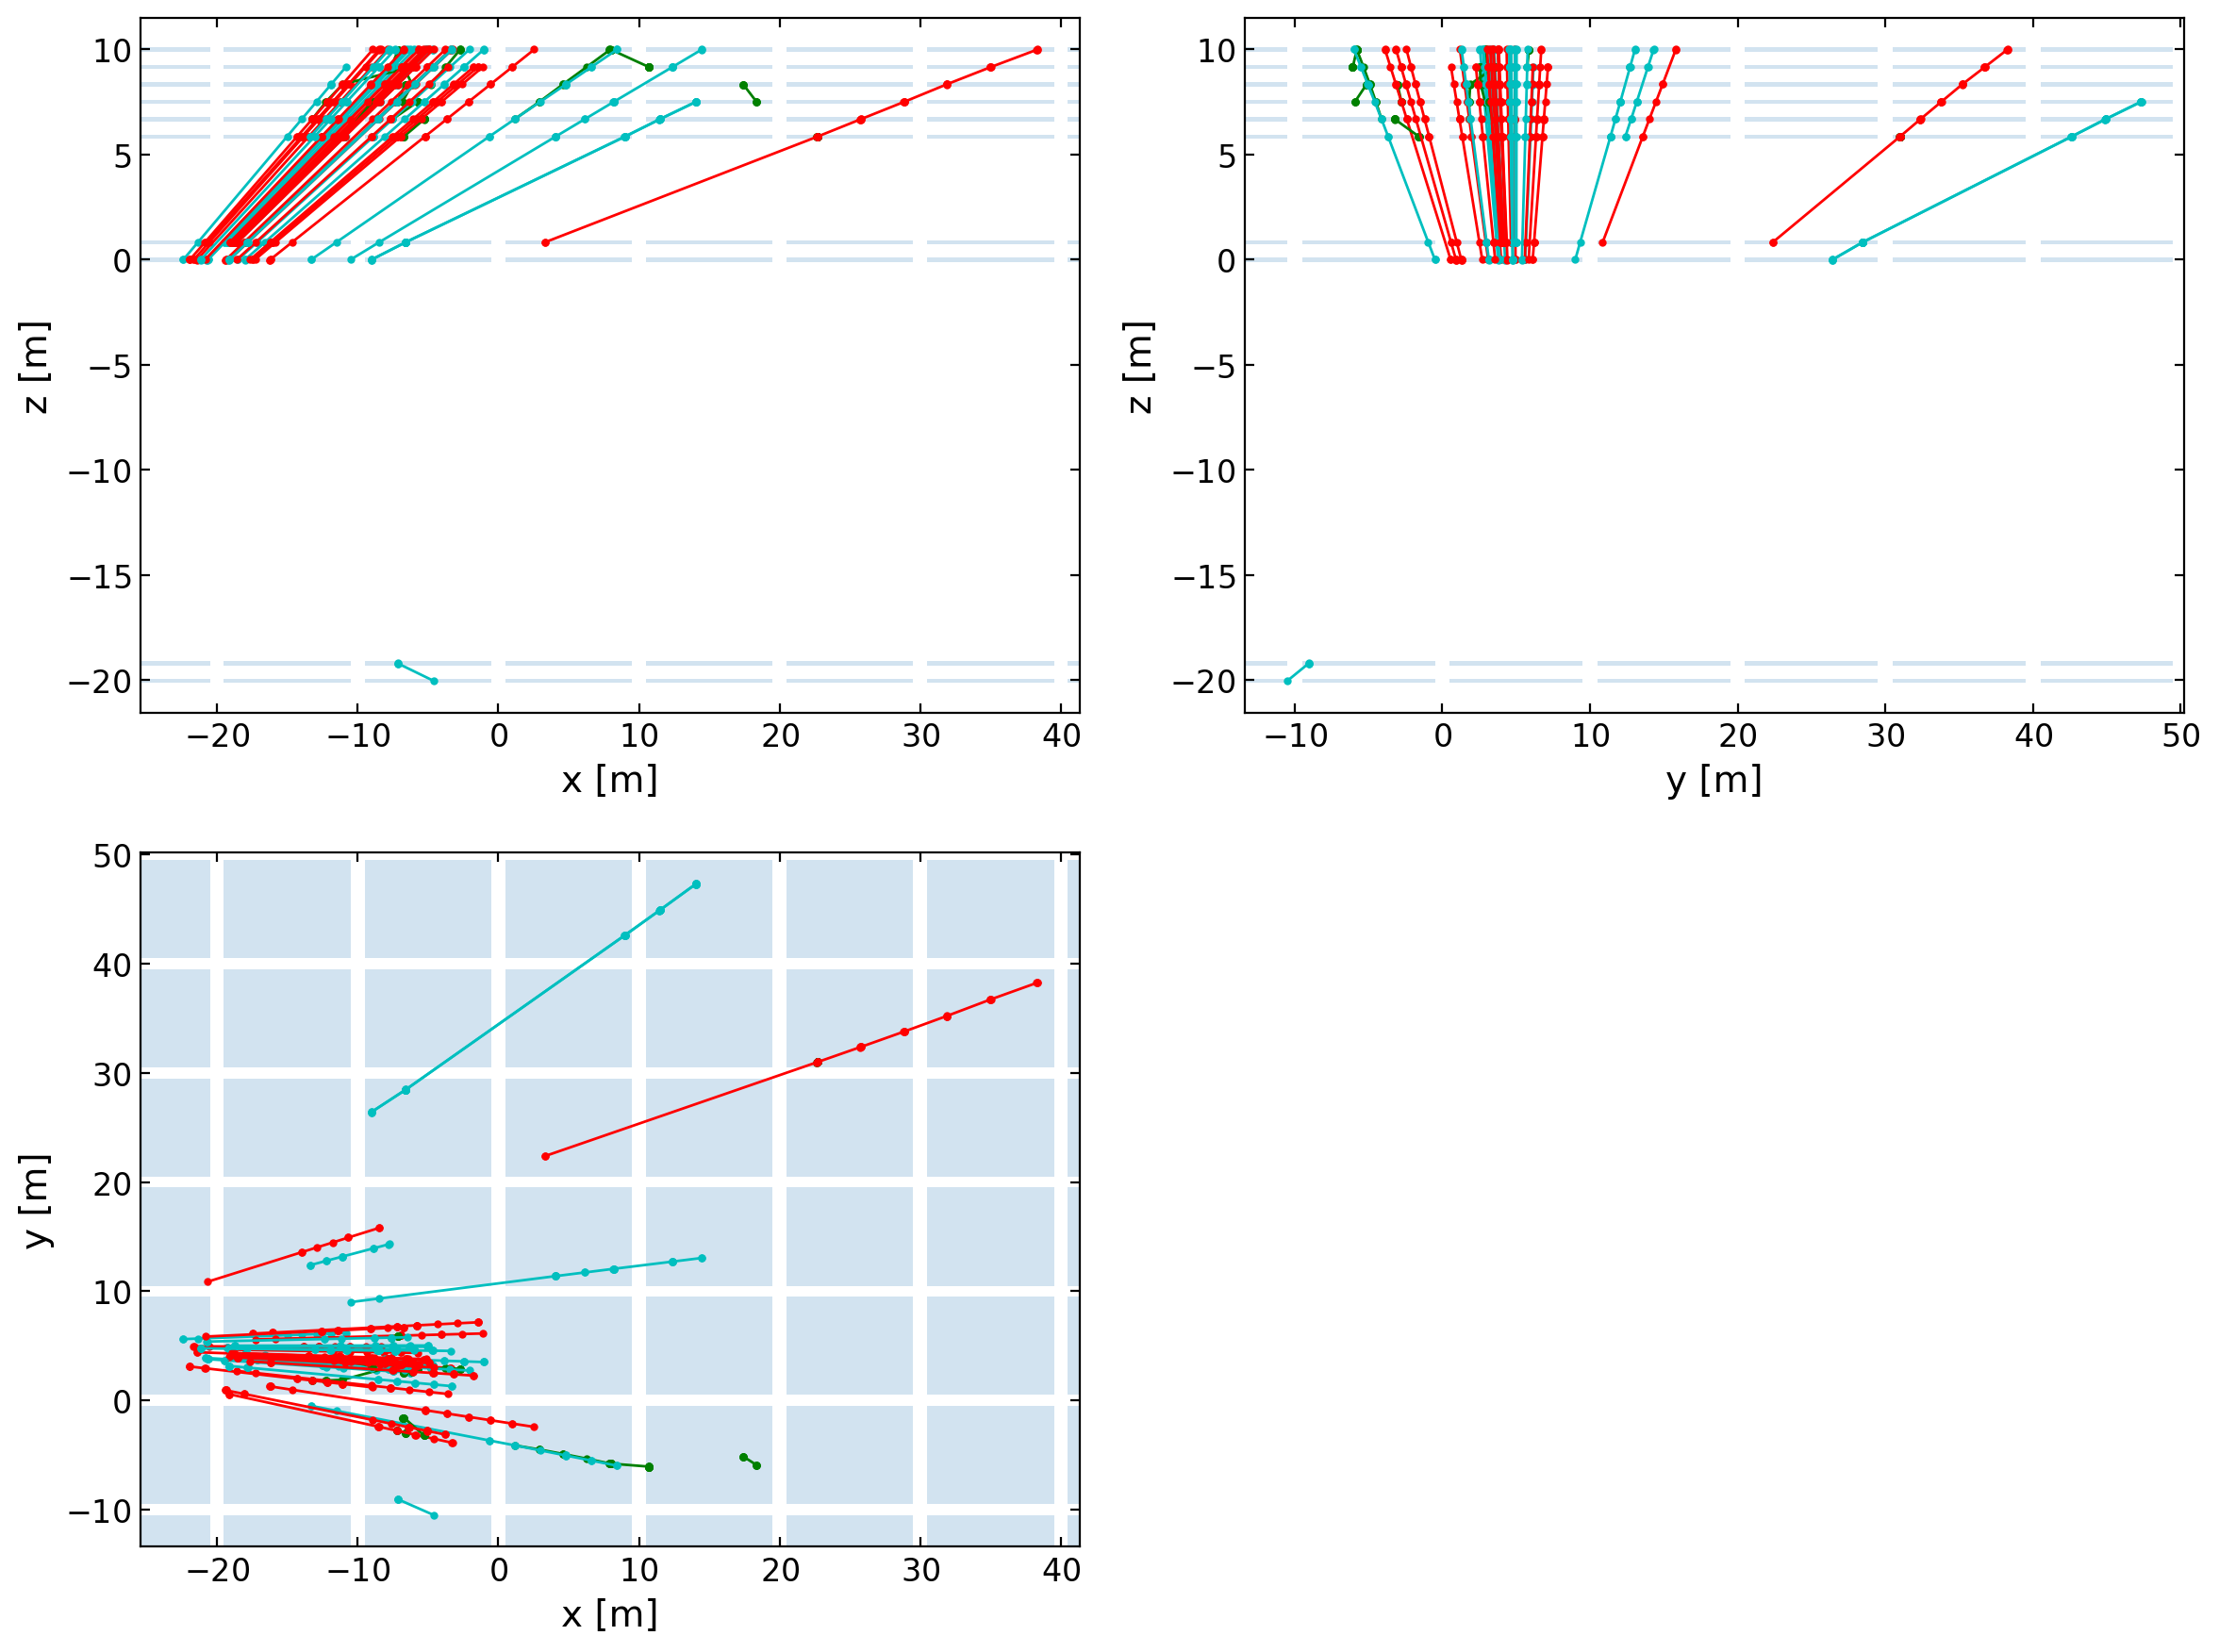

In [9]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(2,2,figsize=(12,9))
for i in range(20):
    ev.EventNumber=i
    # Plot truth
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False,make_legend=False);
fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_vertex=False, disp_first_hit=False,make_legend=False);

# Reconstruction efficiency

In [13]:
filename_recon = os.path.dirname(filename)+"/stat0.root"
# filename_recon = os.path.dirname(filename)+"/stat_seedmod.root"
tfile = root.TFile.Open(filename_recon)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
ev = event.Event(filename_recon, 0, tree_name=tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)
print(branch_list)

res = get_km_alltracks(filename_recon, nevents=10000)

Number of events 10000
['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k

 11%|█         | 1076/10000 [00:01<00:10, 831.49it/s]/tmp/ipykernel_26798/2876637803.py:176: RuntimeWarning: invalid value encountered in sqrt
  results_fit["tracks_recon_error"].append(np.sqrt(tracks_recon_error))
100%|██████████| 10000/10000 [00:12<00:00, 779.71it/s]


In [97]:
data=res
mask_vertex_recon = data["vertices_recon_n"]>=1
mask_track_recon = data["mask_recon_success_track"]
mask = mask_track_recon&mask_vertex_recon

In [113]:
Entry = util.appcut(data["Entry"], mask)
Entry_failed = util.appcut(data["Entry"], ~mask)
Vertices = util.appcut(data["vertices_recon"],mask)
Vertices = np.array([v[0] for v in Vertices])
Vertices_chi2 = np.array([v[0] for v in util.appcut(data["vertices_chi2"],mask)])
Vertices_tracklayers = util.appcut(data["tracks_truth_nlayer"], mask)
Vertices_tracklayers_failed = util.appcut(data["tracks_truth_nlayer"], ~mask)

mask_reconstructible = []
for i in data["tracks_truth_nlayer"]:
    if min(i)>=4 and len(i)>1:
        mask_reconstructible.append(True)
    else:
        mask_reconstructible.append(False)


tracks_purity = util.appcut(data["tracks_purity"], mask )
tracks_purity = np.array([np.mean(i) for i in tracks_purity])

tracks_purity_nonvertex = util.appcut(data["tracks_purity"], (~mask)&mask_reconstructible)
# tracks_purity_nonvertex = util.Utils.flatten1d(tracks_purity_nonvertex)
tracks_purity_nonvertex = np.array([np.mean(i) for i in tracks_purity_nonvertex])


print(len(tracks_purity))
print(sum(mask_vertex_recon&mask_track_recon))


residual = []
for i in tqdm(range(len(Vertices))):
    residual.append([Vertices[i][2]-vertex_CMS[2],
                     Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                    Vertices[i][3], util.quadsum([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])])
    
residual=np.array(residual)

residual_cms = []
for i in tqdm(range(len(Vertices))):
    residual_cms.append([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])
residual_cms=np.array(residual_cms)
    
vertex_CMS_unit = vertex_CMS/util.quadsum(vertex_CMS)
residual_axial  = np.dot(residual_cms[:,:3],vertex_CMS_unit)
residual_radial = np.cross(residual_cms[:,:3],vertex_CMS_unit)
residual_radial = np.array([np.linalg.norm(i) for i in residual_radial])

7944
7944


100%|██████████| 7944/7944 [00:00<00:00, 488177.09it/s]


In [136]:
reload(rt)

<module 'include_modules_root' from '/project/6035200/tomren/jupyter/tracker_6layers/include_modules_root.py'>

53.908900943448955
12.611869999607721


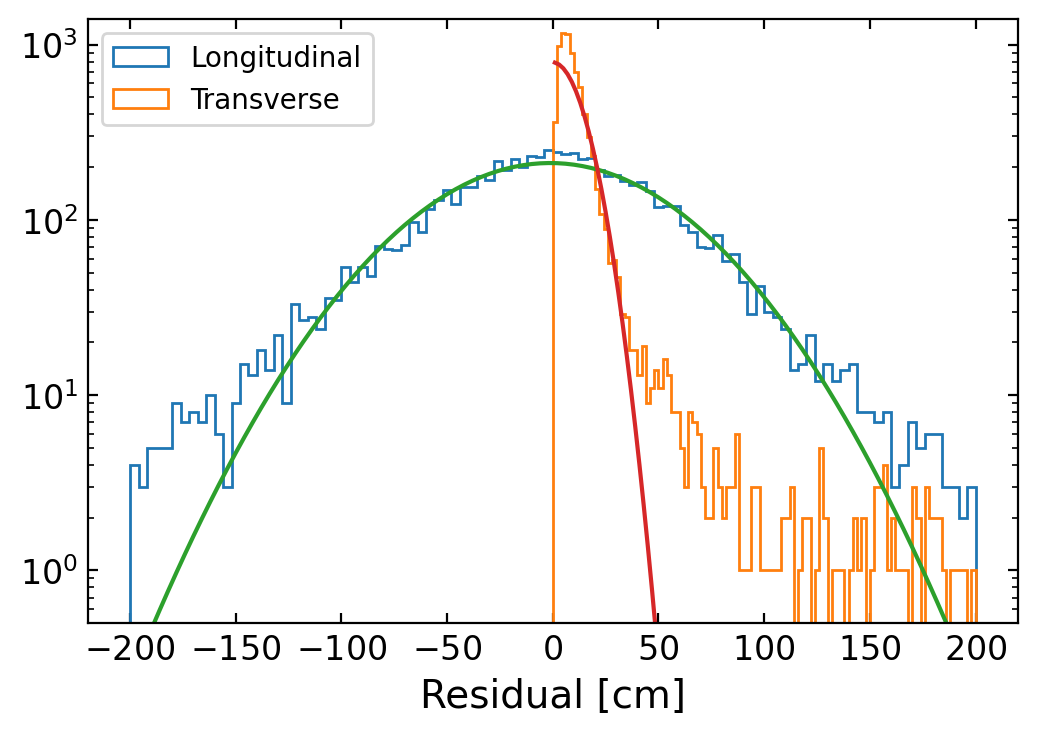

Text(0, 0.5, 'Transverse residual [cm]')

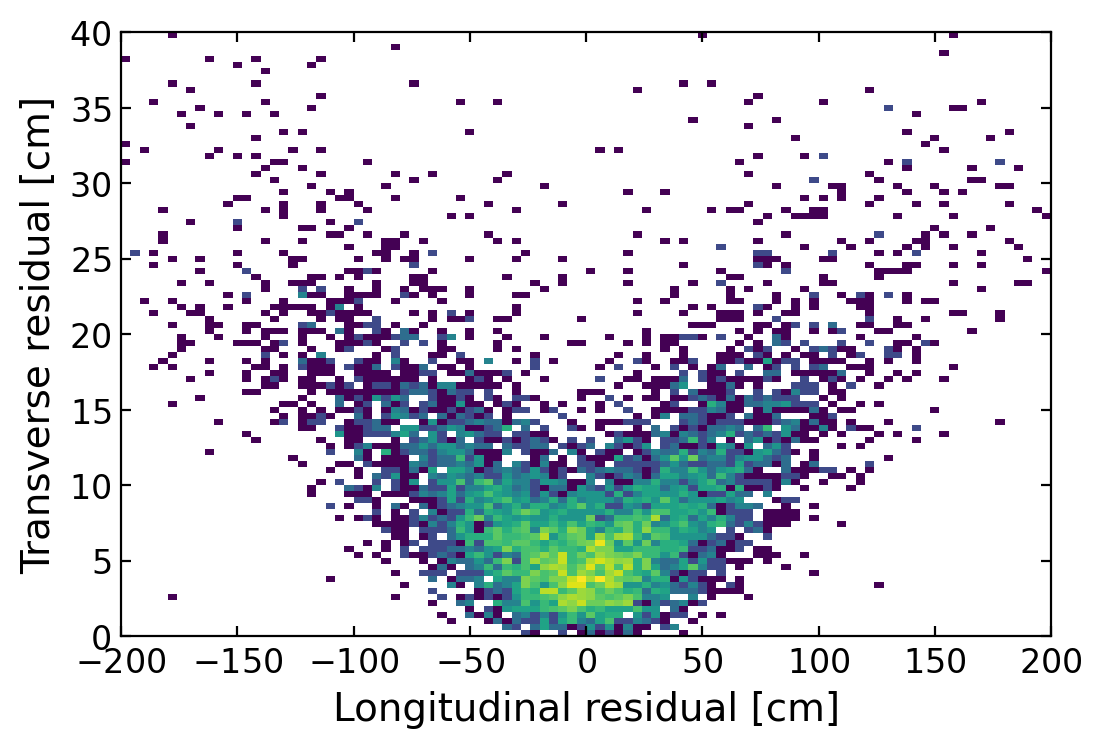

In [147]:
n,ibins,p=hist(residual_axial,range=(-200,200),histtype="step",label="Longitudinal");
n2,ibins2,p=hist(residual_radial,range=(0,200),histtype="step",label="Transverse");

bincenters=0.5*(ibins[1:]+ibins[:-1])
bincenters2=0.5*(ibins2[1:]+ibins2[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1
yerr2=np.sqrt(n2);yerr2[yerr2==0]=1

popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
print(popt[2])
plot(bincenters, util.Utils.Gauss(bincenters,*popt))
popt,pcov = rt.fit_tg(bincenters2,n2,yerr=yerr2,function="gaus",set_constant=[[1,0]],initial_values=[max(n2),0,3],fit_range=(0,30),option="BQS")
print(popt[2])
plot(bincenters2, util.Utils.Gauss(bincenters2,*popt))

yscale("log")
xlabel("Residual [cm]")
legend(fontsize=10,loc="upper left")
ylim(bottom=0.5,top=max([max(n),max(n2)])*1.2)
show()

hist2d(residual_axial, residual_radial,range=((-200,200),(0,40)),bins=(100,100),norm=LogNorm());
xlabel("Longitudinal residual [cm]")
ylabel("Transverse residual [cm]")

1.5350814149311829


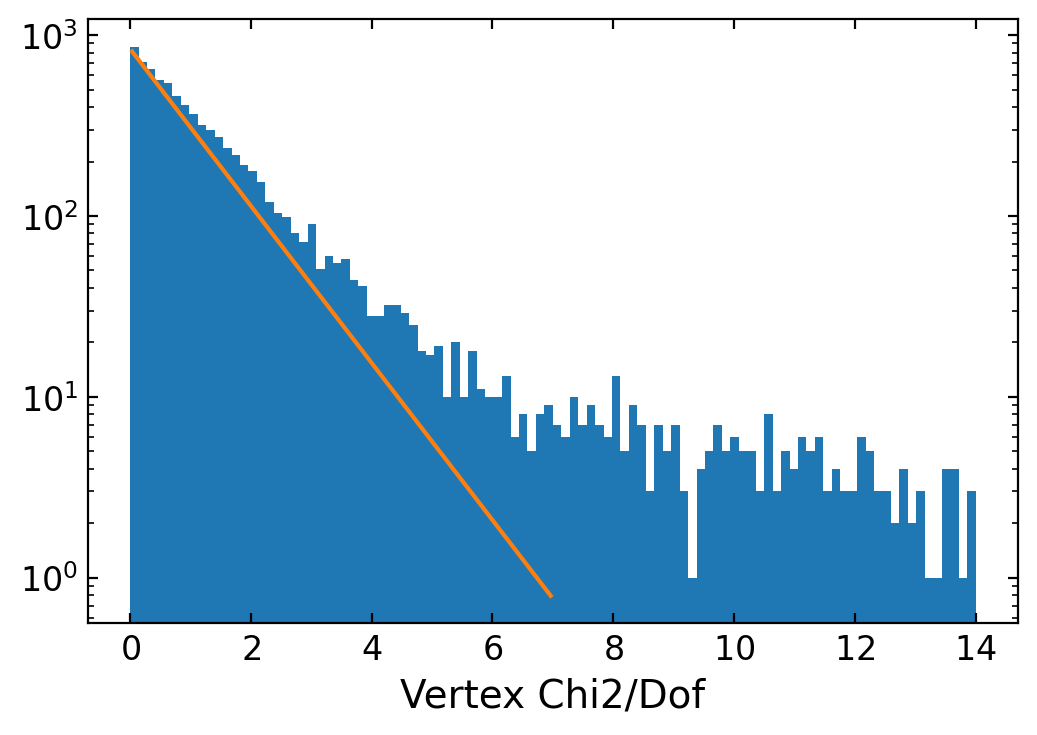

(0.0, 14.0)

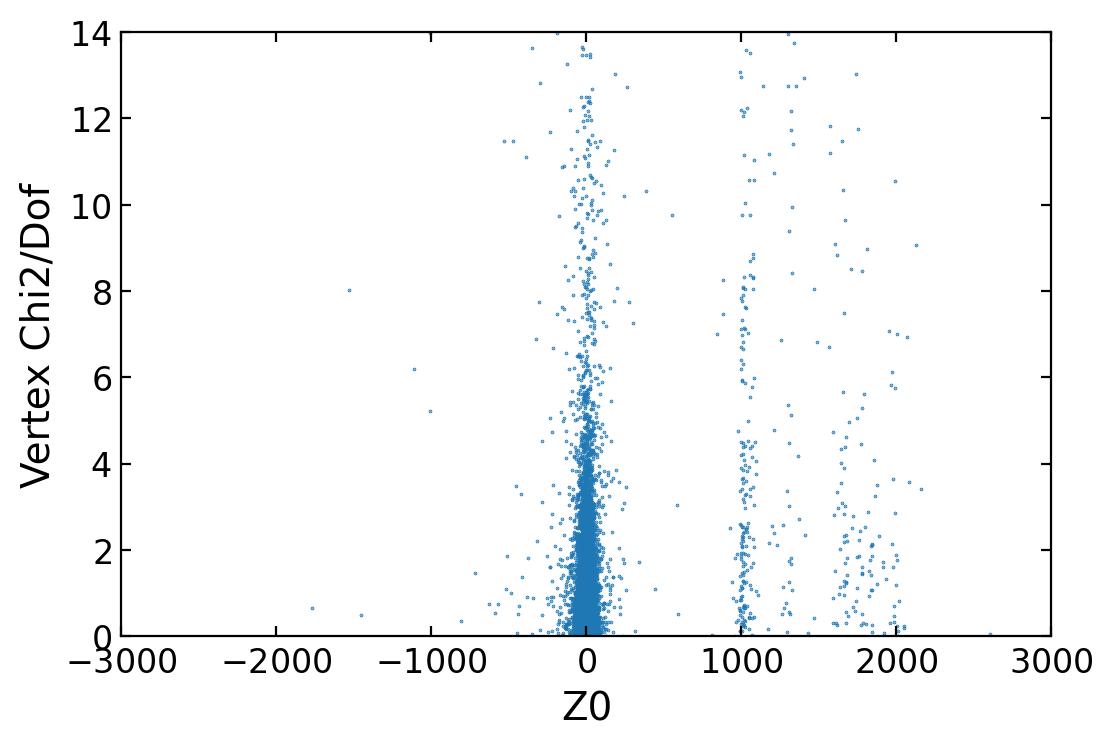

In [65]:
n,ibins,p = hist(Vertices_chi2,range=(0,14));
bincenters = util.Utils.center(ibins)

dof = 2
y = scipy.stats.chi2.pdf(bincenters,dof)
plot(bincenters/dof,y/y[dof]*n[1])
yscale("log")
xlabel("Vertex Chi2/Dof")
print(np.mean(Vertices_chi2))
show()

scatter(residual[:,2], Vertices_chi2,s=0.1);
xlabel("Z0")
ylabel("Vertex Chi2/Dof")
xlim(-3000,3000)
ylim(0,14)

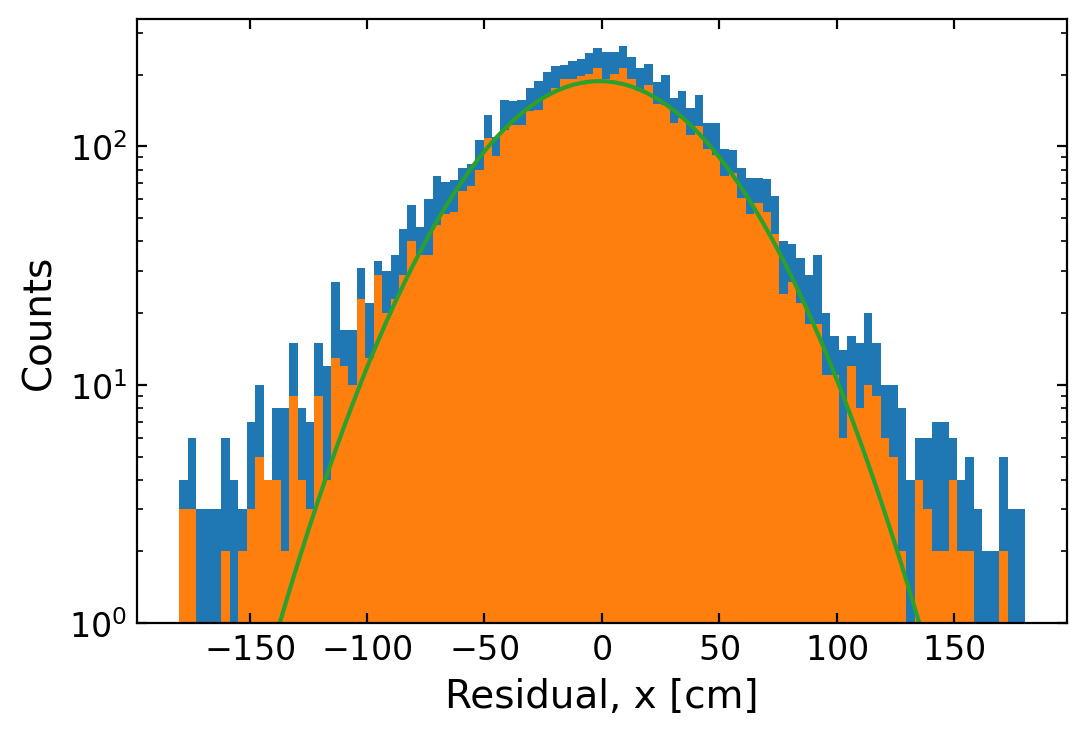

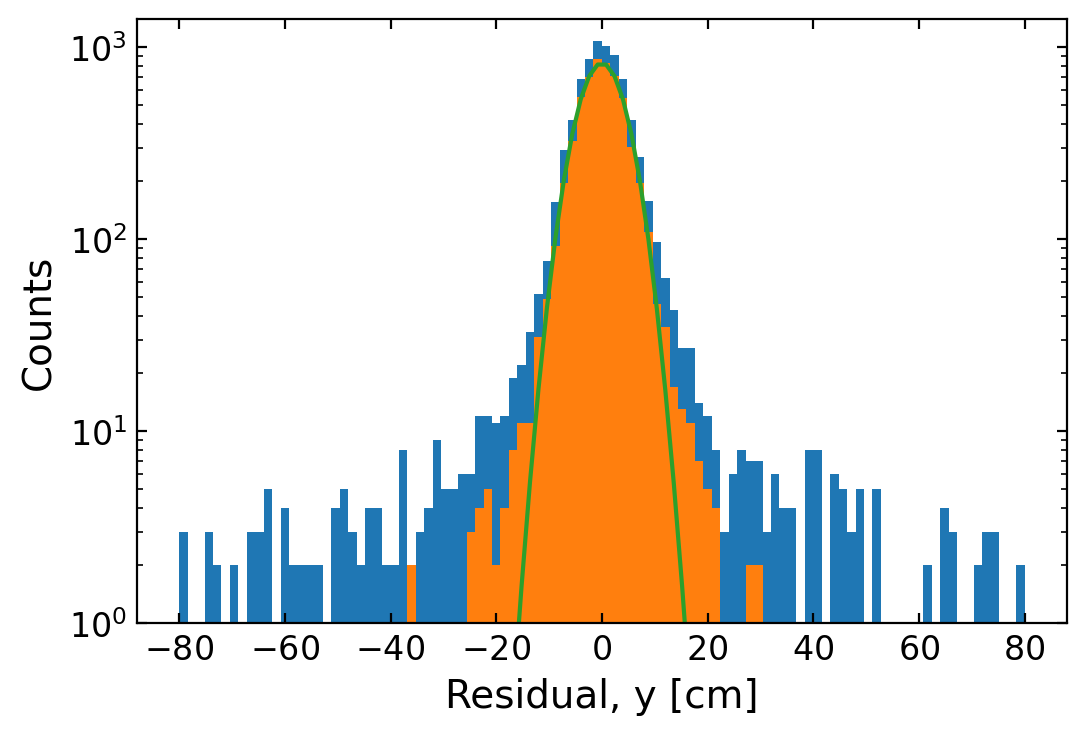

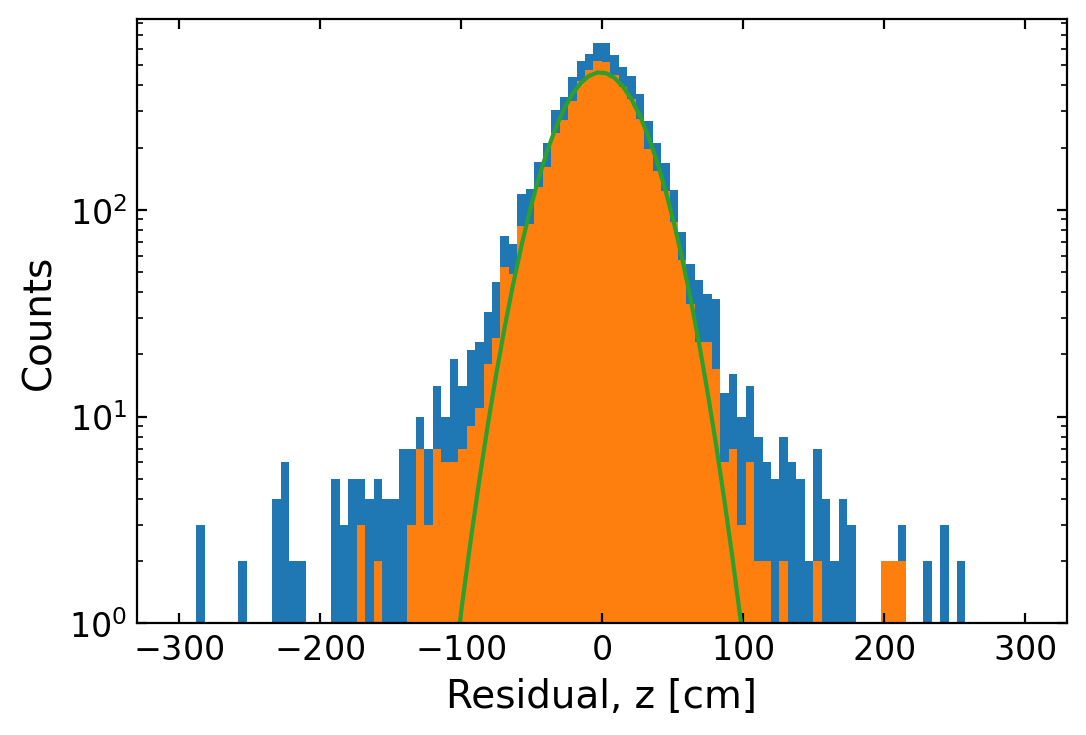

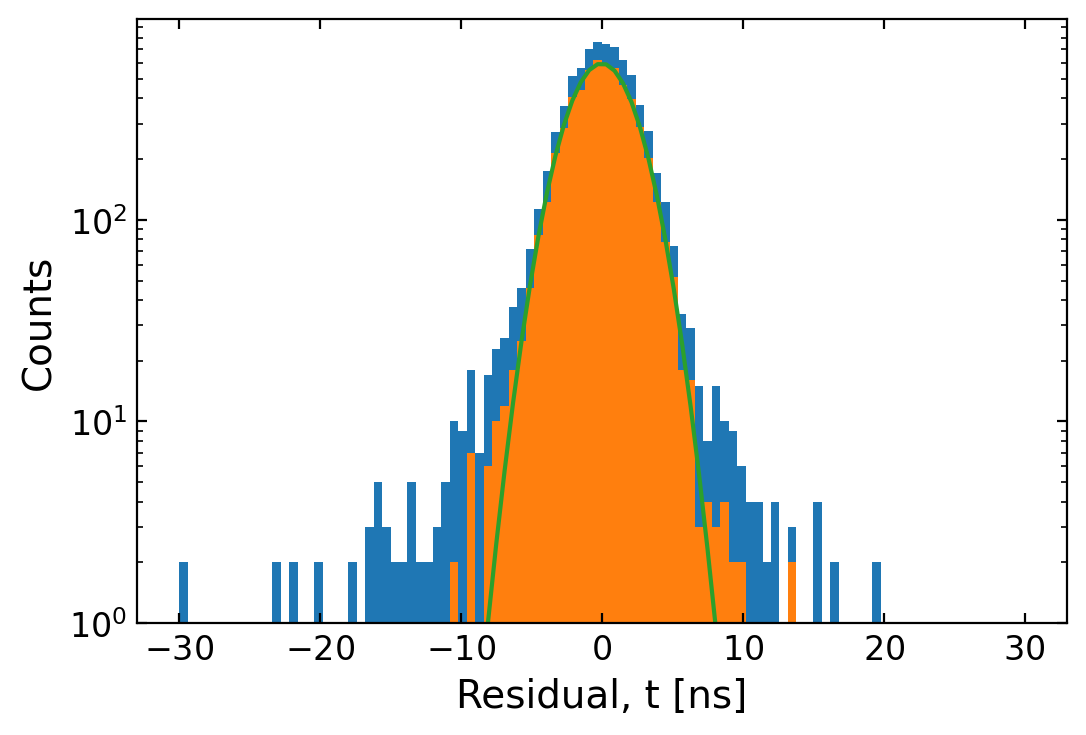

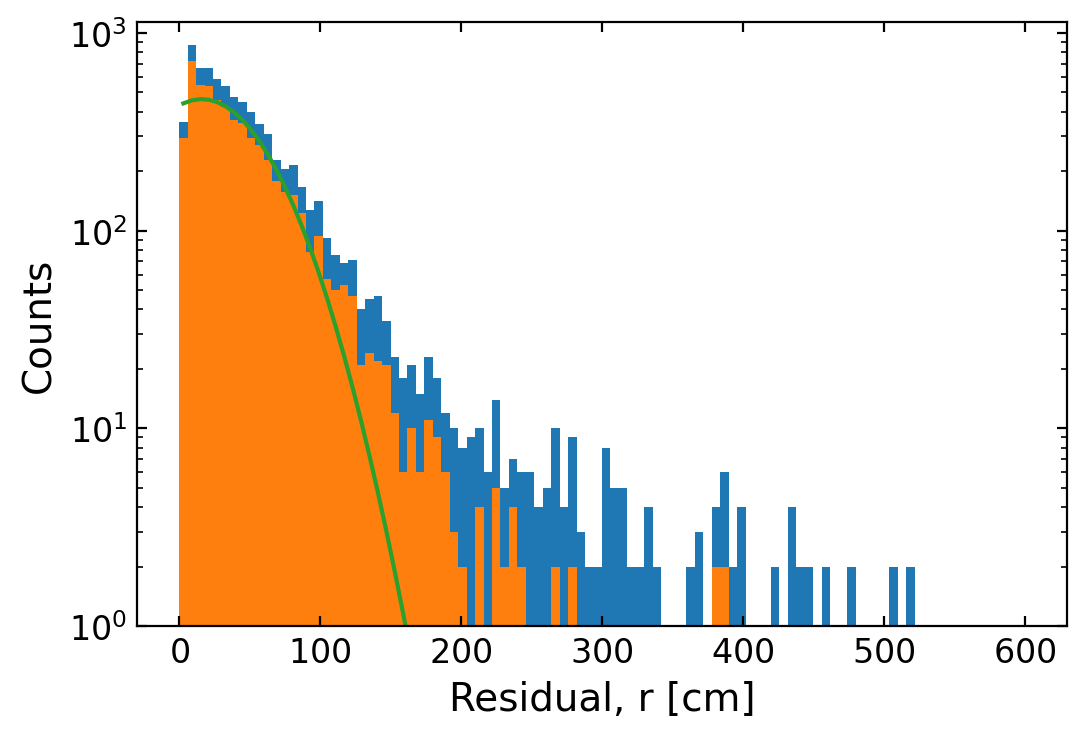

In [66]:
sigmas=[]
labels=["x [cm]", "y [cm]", "z [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-180,180],[-80,80],[-300,300],[-30,30],[0,600]]

for i in range(5):
    # if i<=2:
    #     continue
    n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i]);
    n,ibins,_ = hist(residual[:,i][tracks_purity>0.99],range=plot_ranges[i]);
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1
    
    # Fit round 1
    popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
    perr = np.sqrt(np.diag(pcov))
    # Fit round 2
    mask_fit = (bincenters>(popt[1]-np.abs(popt[2])*3))&(bincenters<(popt[1]+np.abs(popt[2])*3))
    if i==3:
        mask_fit = (bincenters>-10)&(bincenters<10)
    if i==4:
        mask_fit = (bincenters>0)&(bincenters<100)        
    popt,pcov = rt.fit_tg(bincenters[mask_fit],n[mask_fit],yerr=yerr[mask_fit],function="gaus")
    perr = np.sqrt(np.diag(pcov))
    sigmas.append(popt[2])    
    plot(bincenters, util.Utils.Gauss(bincenters,*popt))
    

    
    # print("FWHM", fwhm)
    # print("SIGMA", popt[2])
    ylim(1, max(n0)*1.3)  
    xlabel("Residual, "+labels[i])
    ylabel("Counts")
    yscale("log")
    show()

In [67]:
sigmas

[42.08118748509291,
 4.289371510321781,
 28.496879479605266,
 2.2575809418627437,
 41.29196319744913]

In [38]:
mask_plot = np.abs(residual[:,2]-1000)<100

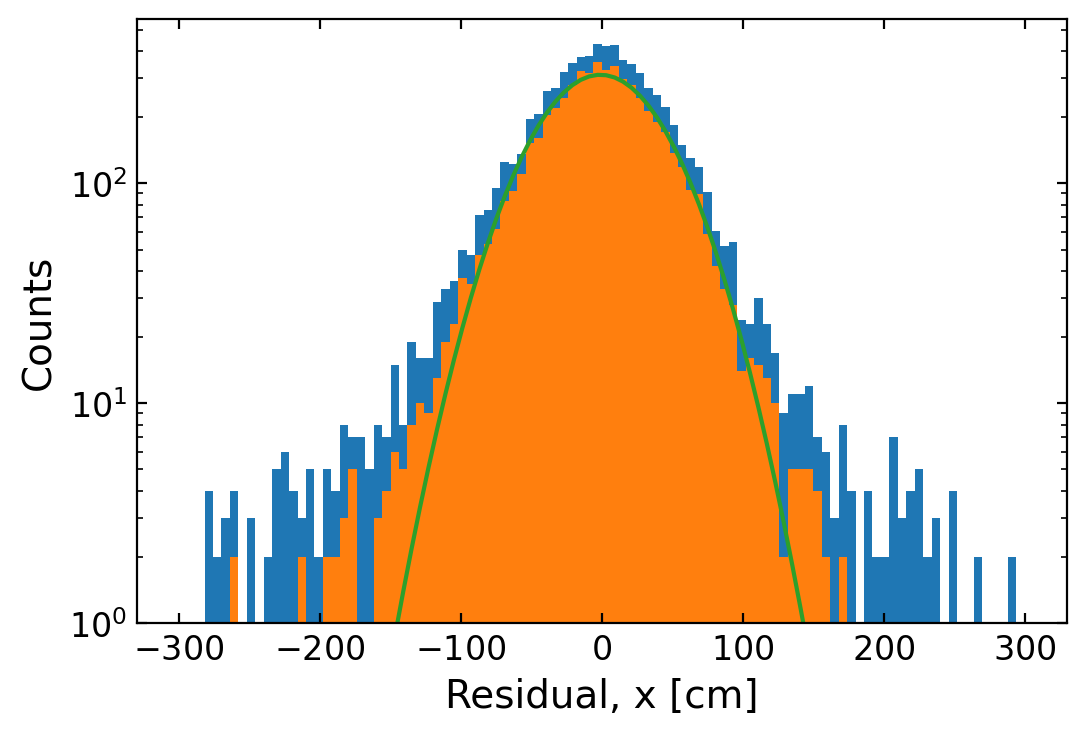

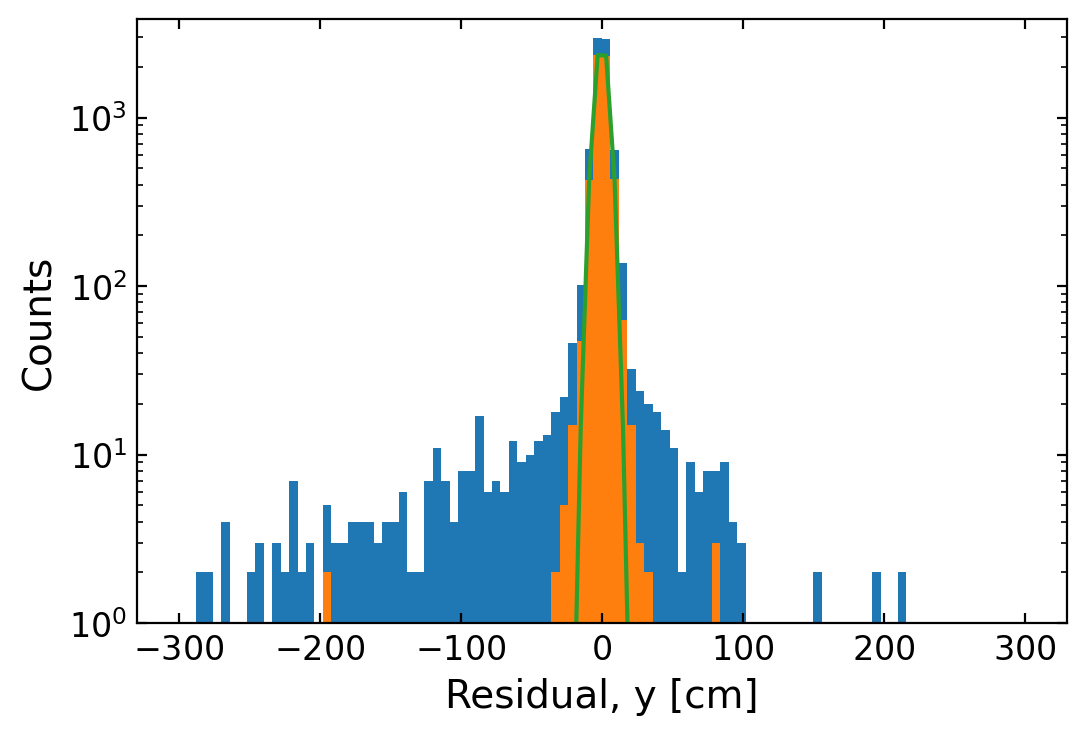

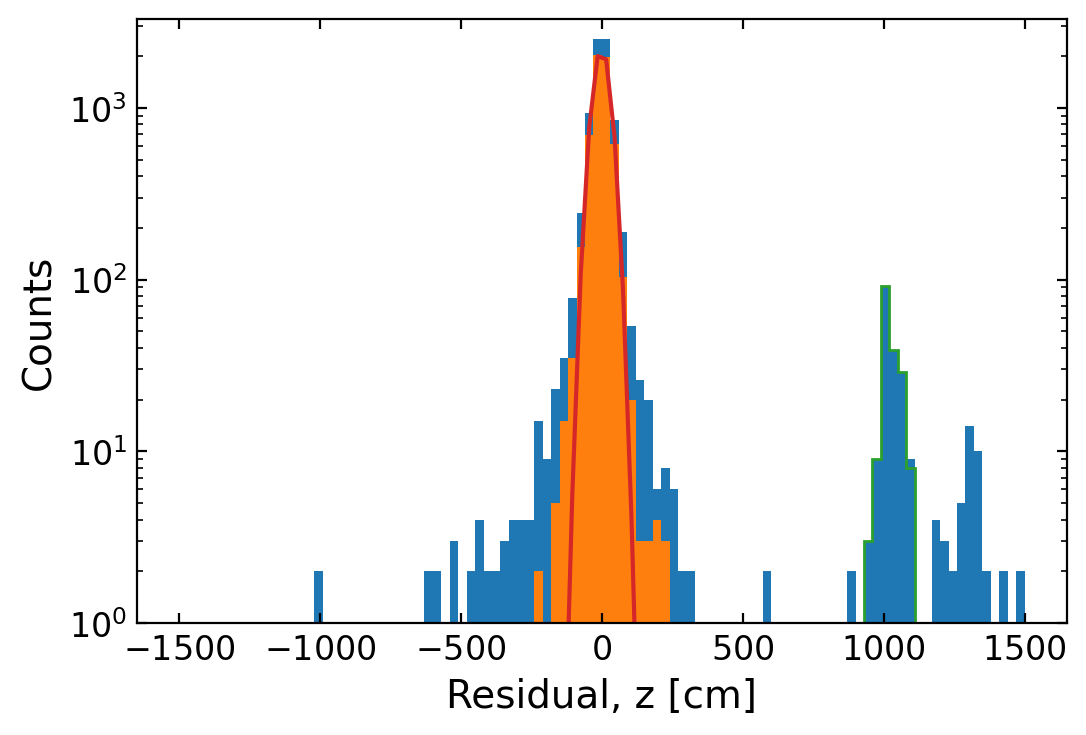

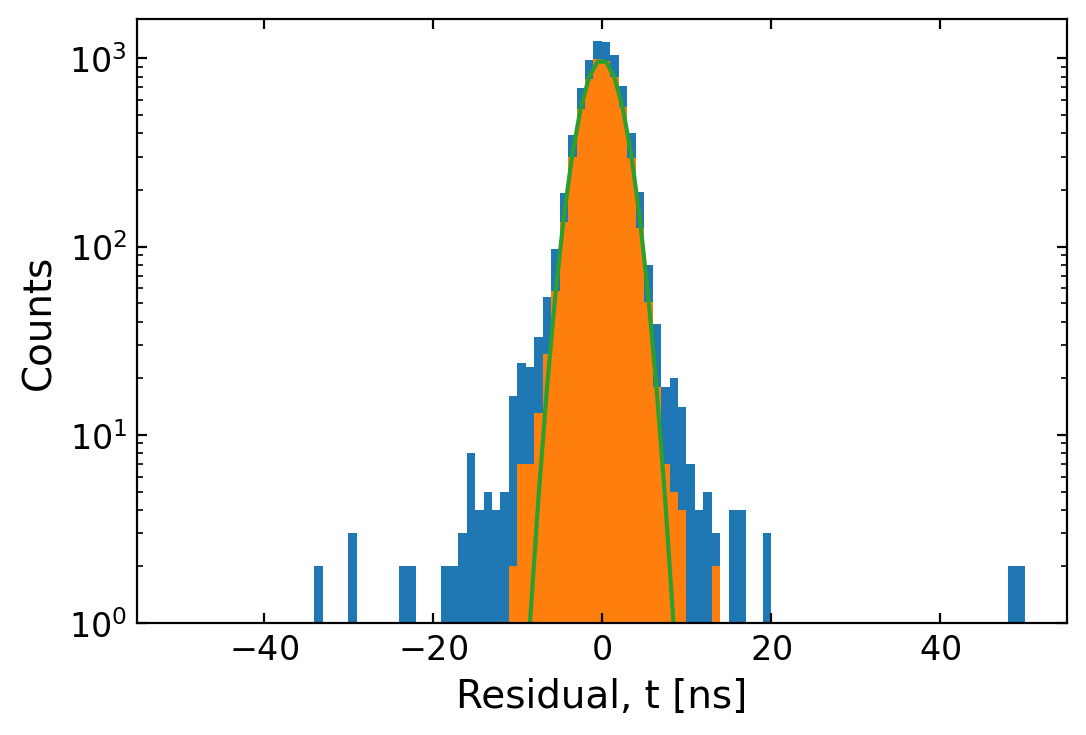

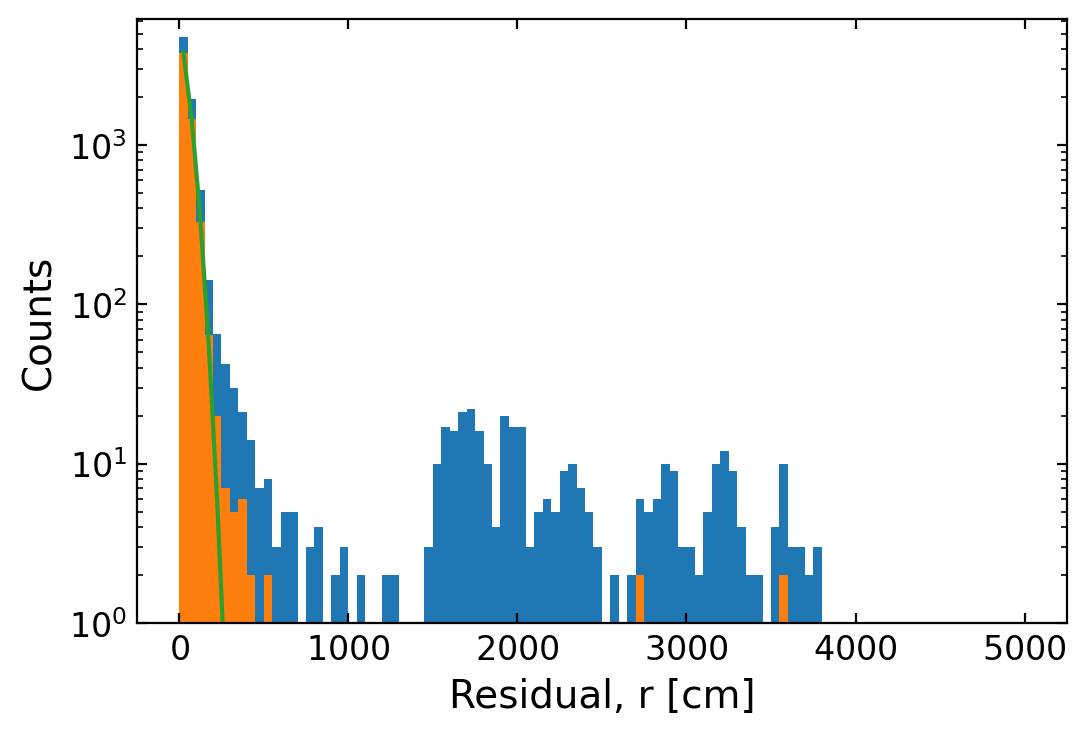

In [70]:
sigmas=[]
labels=["x [cm]", "y [cm]", "z [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-80,80],[-80,80],[-1500,1500],[-30,30],[0,600]]
plot_ranges=[[-300,300],[-300,300],[-1500,1500],[-50,50],[0,5000]]

for i in range(5):
    # if i<=2:
    #     continue
    n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i]);
    n,ibins,_ = hist(residual[:,i][tracks_purity>0.99],range=plot_ranges[i]);
    if i==2:
        hist(residual[:,i][mask_plot],range=plot_ranges[i],histtype="step");
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1
    
    
    # fwhm = util.Utils.fwhm(bincenters,n)
    # fwhm = fwhm[1]-fwhm[0]
    
    # Fit round 1
    popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
    perr = np.sqrt(np.diag(pcov))
    # Fit round 2
    mask_fit = (bincenters>(popt[1]-np.abs(popt[2])*3))&(bincenters<(popt[1]+np.abs(popt[2])*3))
    if i==3:
        mask_fit = (bincenters>-10)&(bincenters<10)
    if i==4:
        mask_fit = (bincenters>0)&(bincenters<200)        
    popt,pcov = rt.fit_tg(bincenters[mask_fit],n[mask_fit],yerr=yerr[mask_fit],function="gaus")
    perr = np.sqrt(np.diag(pcov))
    sigmas.append(popt[2])    
    plot(bincenters, util.Utils.Gauss(bincenters,*popt))

    # print("FWHM", fwhm)
    # print("SIGMA", popt[2])
    ylim(1, max(n0)*1.3)  
    xlabel("Residual, "+labels[i])
    ylabel("Counts")
    yscale("log")
    show()

In [81]:
mask_r  = np.abs(residual[:,4])<100

0.7184038267875126

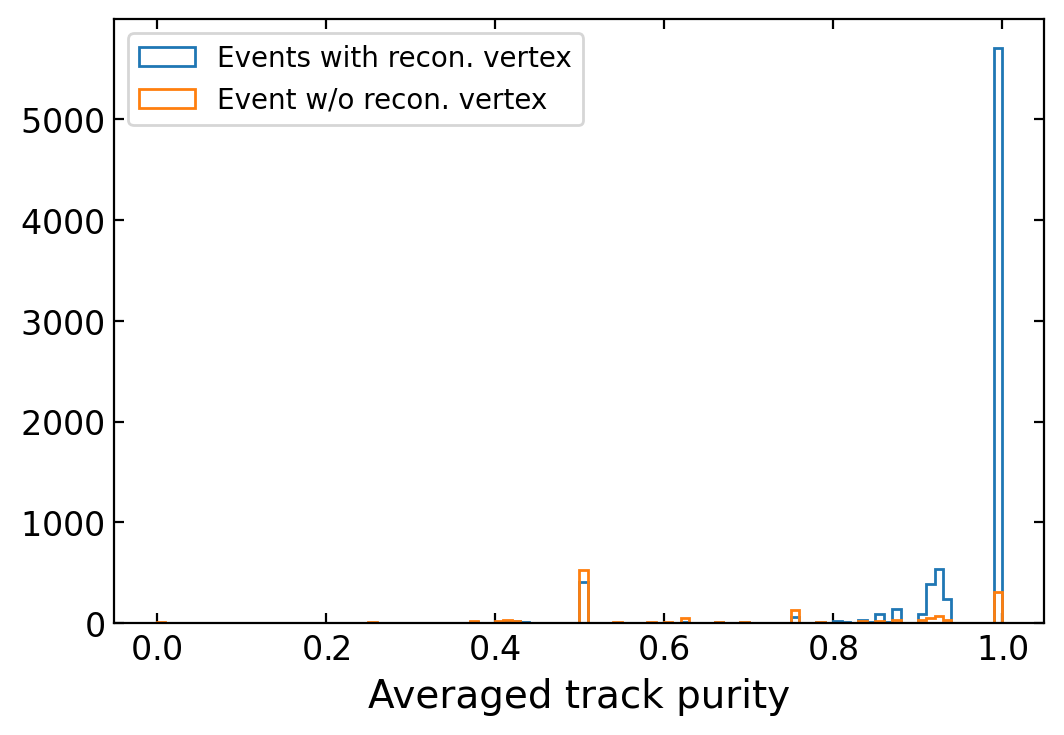

In [114]:
hist(tracks_purity,range=(0,1),bins=100, label="Events with recon. vertex",histtype="step");
hist(tracks_purity_nonvertex,range=(0,1),bins=100, label="Event w/o recon. vertex",histtype="step");
xlabel("Averaged track purity")
legend(fontsize=10,loc="upper left")
sum(tracks_purity>0.99)/len(tracks_purity)

* 80% Events with reconstructed vertex:
    * 70% passed cut of |r|<100cm
    * 10% failed cut
* 20% Events doesn't have reconstructed vertex


In [120]:
print("Non-reconstructible",10000-sum(mask_reconstructible))

Non-reconstructible 683


In [148]:
a = "QS"
"S" in a

True

In [116]:
sum((tracks_purity>0)&(tracks_purity<1)&~mask_r),sum((tracks_purity_nonvertex<1)&(tracks_purity_nonvertex>0))

(797, 1246)

In [41]:
print("Event count",len(data["tracks_truth_n"]))

Event count 10000


In [61]:
sum(mask_vertex_loose)

6683

In [42]:
mask_vertex_loose = (np.abs(residual[:,4])<100)
print("Efficiency", sum(mask_vertex_loose)/len(mask))

Efficiency 0.6683


In [252]:
mask_vertex_loose = (np.abs(residual[:,4])<5500)
print("Efficiency", sum(mask_vertex_loose)/len(mask))

Efficiency 0.8694


In [19]:
print("Fraction of events track purity >0.9 (with r>100):", sum((np.abs(residual[:,4])>50)&(tracks_purity<0.99))/sum(np.abs(residual[:,4])>50))

Fraction of events track purity >0.9 (with r>100): 0.5442196958511738


In [30]:
mask_vertex_loose = (np.abs(residual[:,4])<100)&(tracks_purity>0.99)
print("Efficiency, track purity >0.9:", sum(mask_vertex_loose)/sum(tracks_purity>0.99))

Efficiency, track purity >0.9: 0.5785276073619632


---
Misc

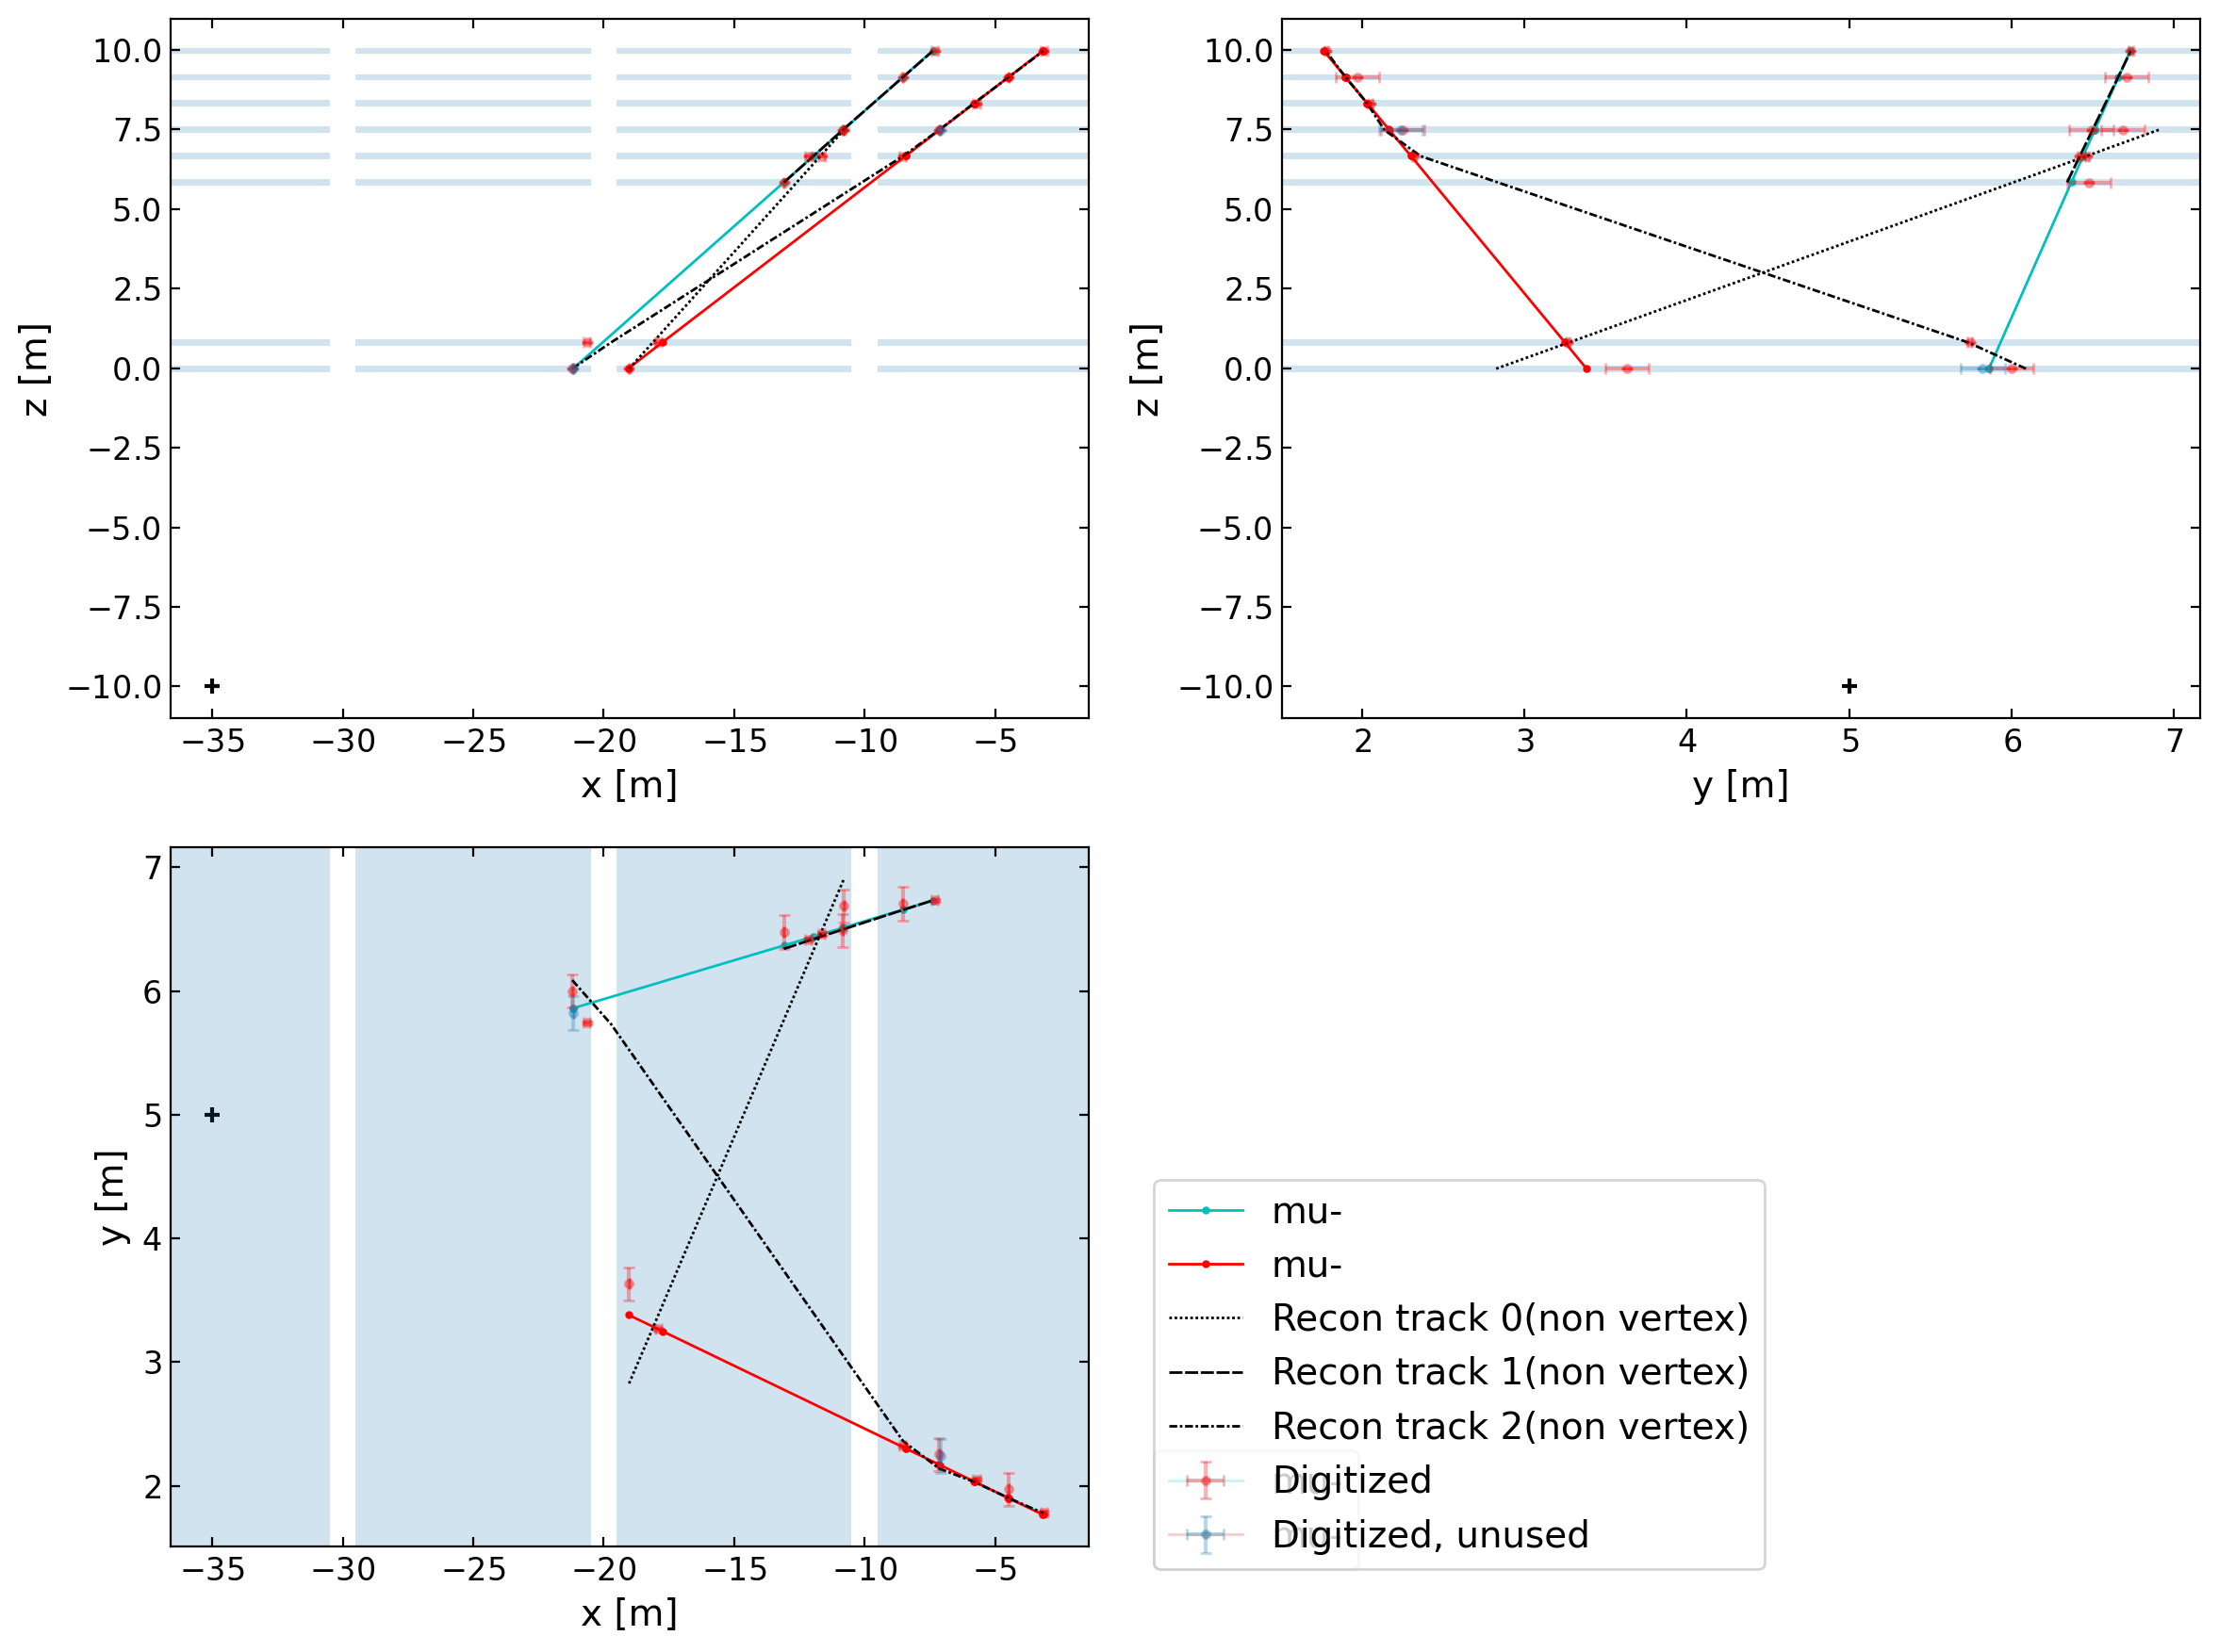

In [103]:
ev.EventNumber = 59

    
# Plot truth
fig,axs=plt.subplots(2,2,figsize=(12,9))
fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=True, disp_first_hit=False);
# Plot the truth vertex
axs=fig.axes
axs[0].scatter(vertex_DET[0],vertex_DET[2],color="black",marker="+")
axs[1].scatter(vertex_DET[1],vertex_DET[2],color="black",marker="+")
axs[2].scatter(vertex_DET[0],vertex_DET[1],color="black",marker="+",label="Vertex Truth ")

# Plot Reconstruction
fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True);


In [213]:
def closest_approach_midpoint(tr1, tr2):

    rel_v = tr2[3:6] - tr1[3:6];
    rel_v2 = np.dot(rel_v, rel_v) 

    displacement = tr2[:3] - tr1[:3]; # position difference
    t_ca = -(  np.dot(displacement, rel_v) - np.dot((tr2[3:6]*tr2[6] - tr1[3:6]*tr1[6]), rel_v)  )/rel_v2;
    
    displacement = tr1[:3] - tr2[:3]; # position difference
    t_ca = (  np.dot(displacement, rel_v) + np.dot((tr2[3:6]*tr2[6] - tr1[3:6]*tr1[6]), rel_v)  )/rel_v2;    
    
    
    print(t_ca)

    pos1 = tr1[:3] + tr1[3:6]*(t_ca - tr1[6]);
    pos2 = tr2[:3] + tr2[3:6]*(t_ca - tr2[6]);

    return (pos1 + pos2)*(0.5), np.linalg.norm((pos1- pos2))


def line_dist(tr1,tr2,t_ca):
    pos1 = tr1[:3] + tr1[3:6]*(t_ca - tr1[6]);
    pos2 = tr2[:3] + tr2[3:6]*(t_ca - tr2[6]);  
    displacement = pos1-pos2
    
    return np.dot(displacement,displacement)

In [214]:
ind=0
tr1 = np.array([ev.Tree.Track_k_m_x0[ind],ev.Tree.Track_k_m_y0[ind],ev.Tree.Track_k_m_z0[ind],ev.Tree.Track_k_m_velX[ind],ev.Tree.Track_k_m_velY[ind],ev.Tree.Track_k_m_velZ[ind],ev.Tree.Track_k_m_t0[ind]])
ind=1
tr2 = np.array([ev.Tree.Track_k_m_x0[ind],ev.Tree.Track_k_m_y0[ind],ev.Tree.Track_k_m_z0[ind],ev.Tree.Track_k_m_velX[ind],ev.Tree.Track_k_m_velY[ind],ev.Tree.Track_k_m_velZ[ind],ev.Tree.Track_k_m_t0[ind]])


In [215]:
tr1,tr2

(array([ 3.94142715e+02,  8.63090000e+03,  1.01003515e+04, -1.70925818e+00,
         1.68737956e+01,  2.55639293e+01,  6.67081053e+01]),
 array([1.24230454e+03, 9.13350000e+03, 1.06101674e+04, 7.95783256e+00,
        1.67123034e+01, 2.30712988e+01, 9.22739054e+01]))

In [216]:
closest_approach_midpoint(tr1,tr2)

2.311733835570479


(array([ 515.30669179, 7587.15684064, 8494.37522611]), 119.67701205405405)

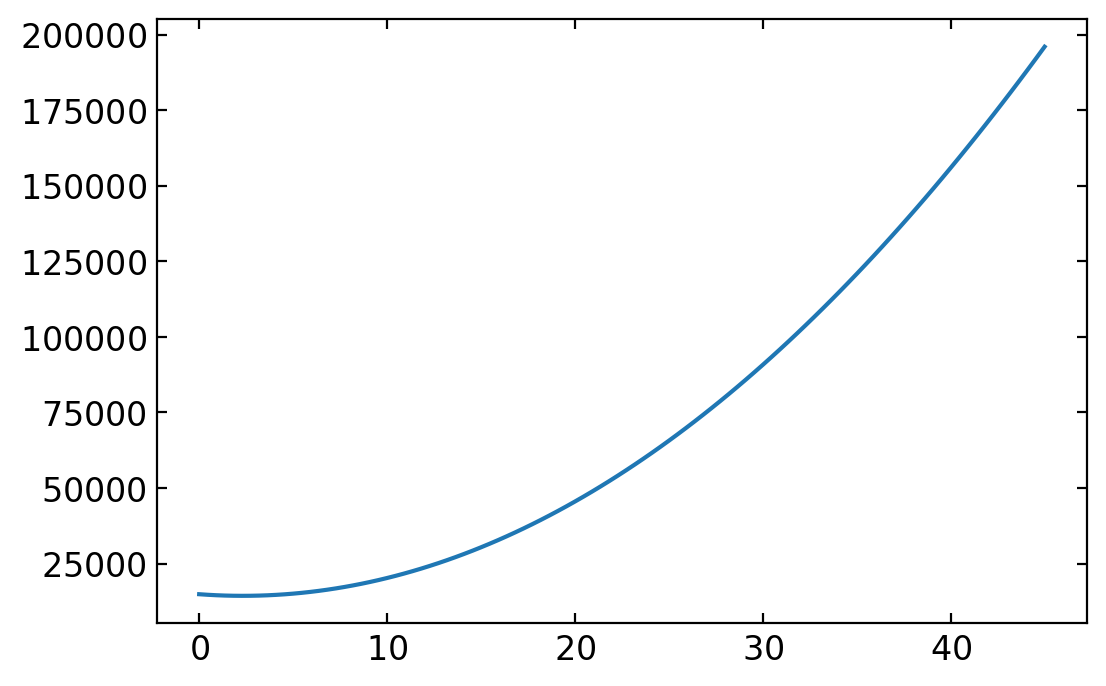

In [209]:
t = np.linspace(0,45,100)
dist = [line_dist(tr1,tr2,ti) for ti in t]
plot(t,dist)